# <center>Image Colorization of Paintings and Historical Photos (SoftUni - Math Concepts for Developers 2019)</center>

---

## <center>Author: Konstantin Georgiev</center>
### <center>Email: dragonflareful@gmail.com</center>



---



### <center>Introduction</center>

&nbsp;&nbsp;&nbsp;Colorization and remastering of old images nowadays is usually done manually by using popular photo editing software like <b>Photoshop</b>. This process is generally a very demanding job that requires extensive research, in order to properly organize the layers of color as well as the proper shading of these images. Sometimes remastering an image can take months. However, with the help of various <b> Deep Learning </b>models it is possible to gradually speed up and even automate this task, whilst producing results that would be similar to those of a professional editor.   

### <center>Motivation</center>
&nbsp;&nbsp;&nbsp;My personal goal for this research was to gain more experience in preprocessing, training, optimizing and evaluating <b>Image-related neural networks</b>. In my previous projects, I have mostly gravitated towards classification tasks, so I have decided to step a little bit further into the field of <b>Generative models</b>. The main reason for that is the fact that they produce unique results, which can be easily compared with their original counterparts and can be interpreted using visualizations instead of different performance metrics.


### <center>Problem statement</center>

&nbsp;&nbsp;&nbsp; This project is basically just me reproducing F. Baldasarre's paper on [Image Colorization using CNN's and ResNet](https://arxiv.org/pdf/1712.03400.pdf) and following E. Wallner's [tutorial](https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d) on this task with some adjustments in terms of the data, preprocessing and training parameters. My main goal is to try to <b>recolorize</b> images of famous painters, which are previously converted to <b>grayscale</b>. After the testing step, I will also try to colorize some images that were originally black-and-white and see how the model performs there.

### <center>Datasets</center>
&nbsp;&nbsp;&nbsp; The main dataset for this project is the resized (smaller) version of [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time), downloaded from <b>Kaggle</b>. It contains over <b>8000</b> images of paintings from <b>50</b> different artists. Due to time constraints, however, I will only be using <b>2500</b> of those images for training.

&nbsp;&nbsp;&nbsp; I am also indirectly using the widely-popular [ImageNet dataset](http://www.image-net.org/), due to the fact that a pre-trained <b>Inception-Resnet-v2</b> model is applied to the main model for feature extraction. 

### <center>Main Libraries</center>

*   <b>Numpy</b> - mainly for storing images as features
*   <b>Matplotlib</b> - visualizing results and model performance
*   <b>Scikit-image</b> - image transformations, reading and plotting
*   <b>Scikit-learn</b> - model data splitting
*   <b>Tensorflow (Keras API)</b> - creating, optimizing, saving and preprocessing deep learning models

&nbsp;&nbsp;&nbsp; This project is also made entirely on <b>Google Colab</b> for performance sake.

### <center>Project Structure</center>



1.   <b> [Acquiring and organizing the dataset.](#section1) </b>
2.   <b> [Exploring the data.](#section2) </b>
3.   <b> [Creating features from the dataset.](#section3) </b>
4.   <b> [Data preprocessing and loading Inception weights.](#section4) </b>
5.   <b> [Creating the Colorizer CNN.](#section5) </b>
6.   <b> [Evaluating the results.](#section6) </b>
7.   <b> [Further optimizations.](#section7) </b>
8.   <b> [Testing the model with images of unknown color.](#section8) </b>
9.   <b> [Conclusion.](#section9) </b>







Let's begin by importing our libraries and modules. I'll also set a few parameters for <b>matplotlib</b> for grid hiding and size, since I'll be mostly plotting images. And of course, a seed of <i>42</i> for reproducible results.

In [2]:
!pip install joblib

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import joblib
import glob
import random
import json
import tensorflow as tf

from google.colab import files

from skimage.io import imread, imsave, imshow
from skimage.transform import resize, rotate, rescale
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

seed = 42
random.seed = seed
np.random.seed = seed

<a id='section1'></a>
### Acquiring and organizing the dataset

I'll first use <b> Google Colab </b> to mount my drive so I can easily load and save data from my <b> Google Drive</b>.

In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Here I've set a few paths, which I'll need later on for easier feature saving and loading. To run this project, you will also need a <b>kaggle.json</b> file, which contains your credentials for <b>Kaggle</b>, in order to connect with their API and download datasets. You can learn more on how to download <b>Kaggle</b> datasets from <b>Google Colab</b> from this [post](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab).


In [0]:
loaded_features_path = 'drive/My Drive/Colab Notebooks/Image Colorization/features.jbl'
kaggle_file_path = 'drive/My Drive/Colab Notebooks/Image Colorization/kaggle.json'
inception_weights_path = 'drive/My Drive/Colab Notebooks/Image Colorization/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5'
trained_model_path = 'drive/My Drive/Colab Notebooks/Image Colorization/'
test_image_path = 'drive/My Drive/Colab Notebooks/Image Colorization/test_images/'

What I'm essentially doing here is just installing the <b>Kaggle API</b>, creating a folder for the credentials file and changing the permissions for security. Then I can print a list of the current datasets on <b> Kaggle </b> and choose the one I want to download and unzip.

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp "drive/My Drive/Colab Notebooks/Image Colorization/kaggle.json" ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d ikarus777/best-artworks-of-all-time
!unzip 'best-artworks-of-all-time.zip'
!unzip 'resized.zip'

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          47342  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          58162  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          31009  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          31598  
bigquery/crypto-ethereum-classic                          

The dataset has been downloaded, so let's choose a few input parameters for our model. For this research, I will use the <b>resized</b> version of the dataset, which will be <i> resized</i> even more. The parameters I have set are a sample size of <b>2500</b> images with a shape of <b>256x256x3</b> (later the images will be converted to grayscale of course).

In [0]:
image_dir = 'resized/'
image_width = 256
image_height = 256
image_channels = 3
image_sample_size = 2500

The code below is just for organizing the images into separate folders, depending on the label names and it will ease my work in the exploration part in the next step. To do this, I will first create a set with the names of all the painters.

In [0]:
def create_labels(directory):
    labels = []
    for image in os.listdir(directory):
      filename = image.split('.')
      label = filename[0].split('_')
      result = ""
      for word in label:
        if not word.isdigit():
          result = result + word + '_'
      labels.append(result[:-1])
    return set(labels)

The set now contains all of the unique painter names. I can now convert it to a list, since I prefer working with lists.

In [0]:
image_labels = create_labels(image_dir)
image_labels = list(image_labels)

In [8]:
print(image_labels)

['Alfred_Sisley', 'Gustave_Courbet', 'El_Greco', 'Caravaggio', 'Amedeo_Modigliani', 'Pablo_Picasso', 'Jackson_Pollock', 'Frida_Kahlo', 'Vasiliy_Kandinskiy', 'Hieronymus_Bosch', 'Pierre-Auguste_Renoir', 'Diego_Velazquez', 'Eugene_Delacroix', 'Pieter_Bruegel', 'Mikhail_Vrubel', 'Georges_Seurat', 'Francisco_Goya', 'Marc_Chagall', 'Henri_Rousseau', 'Diego_Rivera', 'Henri_de_Toulouse-Lautrec', 'Camille_Pissarro', 'Edvard_Munch', 'Paul_Klee', 'Rembrandt', 'Edgar_Degas', 'Joan_Miro', 'Piet_Mondrian', 'Paul_Gauguin', 'Andy_Warhol', 'Gustav_Klimt', 'Leonardo_da_Vinci', 'Claude_Monet', 'Sandro_Botticelli', 'Kazimir_Malevich', 'Henri_Matisse', 'Jan_van_Eyck', 'William_Turner', 'Raphael', 'Peter_Paul_Rubens', 'Andrei_Rublev', 'Salvador_Dali', 'Edouard_Manet', 'Titian', 'Rene_Magritte', 'Michelangelo', 'Giotto_di_Bondone', 'Vincent_van_Gogh', 'Albrecht_Dürer', 'Paul_Cezanne']


Next I will iterate over the filenames again, creating folders for each unique label and moving each of the files to their respective folder with some pattern matching.

In [0]:
def create_label_folders(directory, labels):
    for label in labels:
      label_dir = directory + '{}'.format(label)
      if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        
    for image in glob.glob('resized/*.jpg'):
      
      filename = image.split('.')
      label = filename[0].split('_')
      result = ""
      for word in label:
        if not word.isdigit():
          result = result + word + '_'
      result = result[:-1]
      #print(image)
      #print(result + '/' + image.split('/')[1])
      if result.split('/')[1] in labels:
        os.rename(image, result + '/' + image.split('/')[1])
    
    print('Created folders for labels.')

In [10]:
create_label_folders(image_dir, image_labels)

Created folders for labels.


<a id='section2'></a>
### Exploring the data

In the exploration step I want to just introduce myself to the dataset a little bit. I'll start by printing and plotting the class distributions. I'll use the list of unique painters that I made in the previous step. 

In [0]:
def get_labels_and_class_distributions(directory, labels, title=''):
    filenames = []
    class_lengths = []
    for label in labels:
        label_dir = directory + '{}'.format(label)
        images = [label + '/' + im for im in os.listdir(label_dir)]
        filenames.extend(images)
        print("{0} photos of {1}".format(len(images), label)) 
        class_lengths.append(len(images))
        
    print('Image sample total: ', len(filenames))
    plt.bar(range(len(class_lengths)), class_lengths)
    #plt.xticks(range(len(labels)), labels)
    plt.xticks([])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    return filenames

259 photos of Alfred_Sisley
59 photos of Gustave_Courbet
87 photos of El_Greco
55 photos of Caravaggio
193 photos of Amedeo_Modigliani
439 photos of Pablo_Picasso
24 photos of Jackson_Pollock
120 photos of Frida_Kahlo
88 photos of Vasiliy_Kandinskiy
137 photos of Hieronymus_Bosch
336 photos of Pierre-Auguste_Renoir
37 photos of Diego_Velazquez
31 photos of Eugene_Delacroix
134 photos of Pieter_Bruegel
171 photos of Mikhail_Vrubel
43 photos of Georges_Seurat
291 photos of Francisco_Goya
239 photos of Marc_Chagall
70 photos of Henri_Rousseau
70 photos of Diego_Rivera
81 photos of Henri_de_Toulouse-Lautrec
91 photos of Camille_Pissarro
67 photos of Edvard_Munch
188 photos of Paul_Klee
262 photos of Rembrandt
702 photos of Edgar_Degas
102 photos of Joan_Miro
84 photos of Piet_Mondrian
311 photos of Paul_Gauguin
181 photos of Andy_Warhol
117 photos of Gustav_Klimt
143 photos of Leonardo_da_Vinci
73 photos of Claude_Monet
164 photos of Sandro_Botticelli
126 photos of Kazimir_Malevich
186 pho

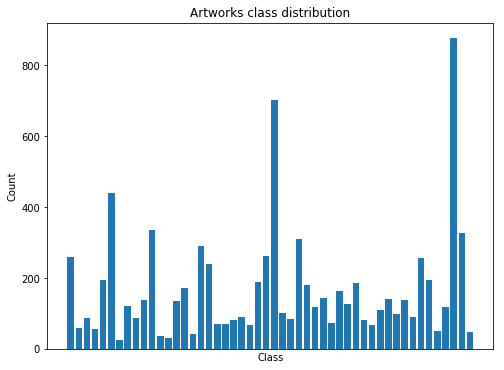

In [12]:
image_filenames = get_labels_and_class_distributions(image_dir, image_labels, title='Artworks class distribution')

In [13]:
print(len(image_filenames))

8355


The classes are unsurprisingly pretty unbalanced but at least the are no missing labels or images, which is good. Next let's do some visualizations on the actual images. I'll make a simple helper-function for reading and resizing the images, according to the previously defined input parameters.

In [0]:
def read_image(src, width, height, channels, preserve_range=False):
    img = imread(src)
    if preserve_range:
      img_resized = resize(img, (width, height, channels), mode='reflect', preserve_range=True)
    else:
      img_resized = resize(img, (width, height, channels), mode='reflect')
    return img_resized

The plotting function will be used to display a random subset of samples from the dataset by creating a squared matrix of subplots. For a nicer visualization, I'll tweak the spacing and remove the ticks from the images, as well as plot the painter names as a title for every sample.

In [0]:
def plot_images(directory, labels, image_width=image_width, image_height=image_height, image_channels=image_channels,
                examples=25, disp_labels=True): 
  
    if not math.sqrt(examples).is_integer():
      print('Please select a valid number of examples.')
      return
    
    imgs = []
    classes = []
    for i in range(examples):
        rnd_idx_cl = np.random.randint(0, len(labels))
        rnd_class = labels[rnd_idx_cl]
        rnd_idx = np.random.randint(0, len(os.listdir(directory + '/' + rnd_class)))
        filename = os.listdir(directory + '/' + rnd_class)[rnd_idx]
        img = read_image(os.path.join(directory + '/' + rnd_class, filename), width=image_width, height=image_height, 
                        channels=image_channels)
        imgs.append(img)
        classes.append(rnd_class)
    
    
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)),figsize=(15,15),
    subplot_kw = {'xticks':[], 'yticks':[]},
    gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    for i, ax in enumerate(axes.flat):
        if disp_labels == True:
          ax.title.set_text(classes[i])
        ax.imshow(imgs[i])

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


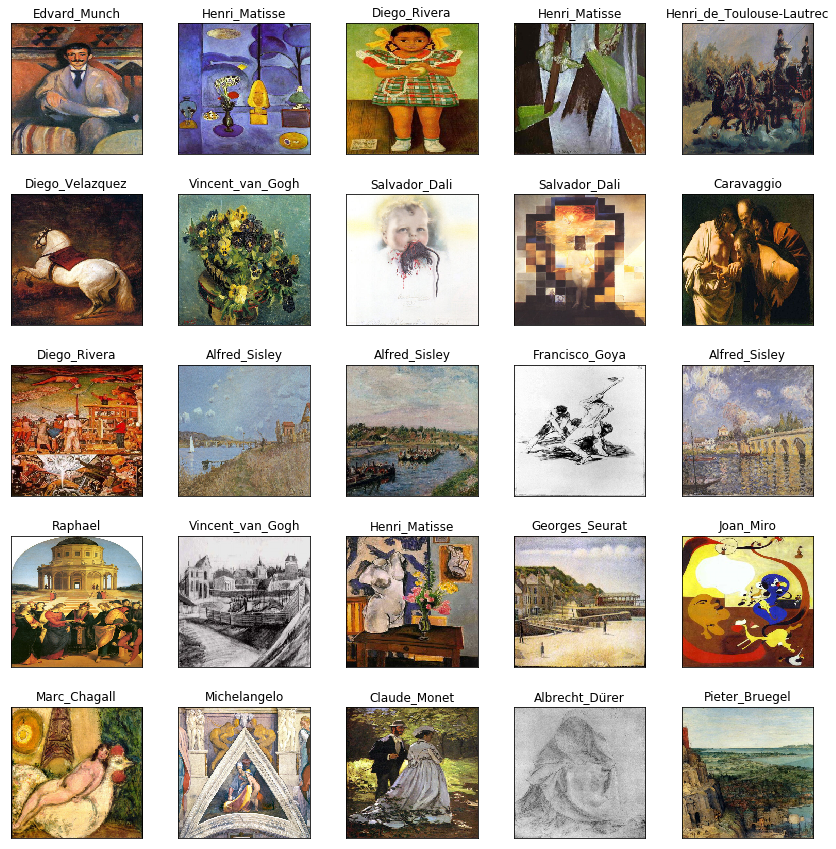

In [16]:
plot_images(image_dir, image_labels)

Now we can also use this function to plot a larger subset of images like <b>100</b> samples, for example.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


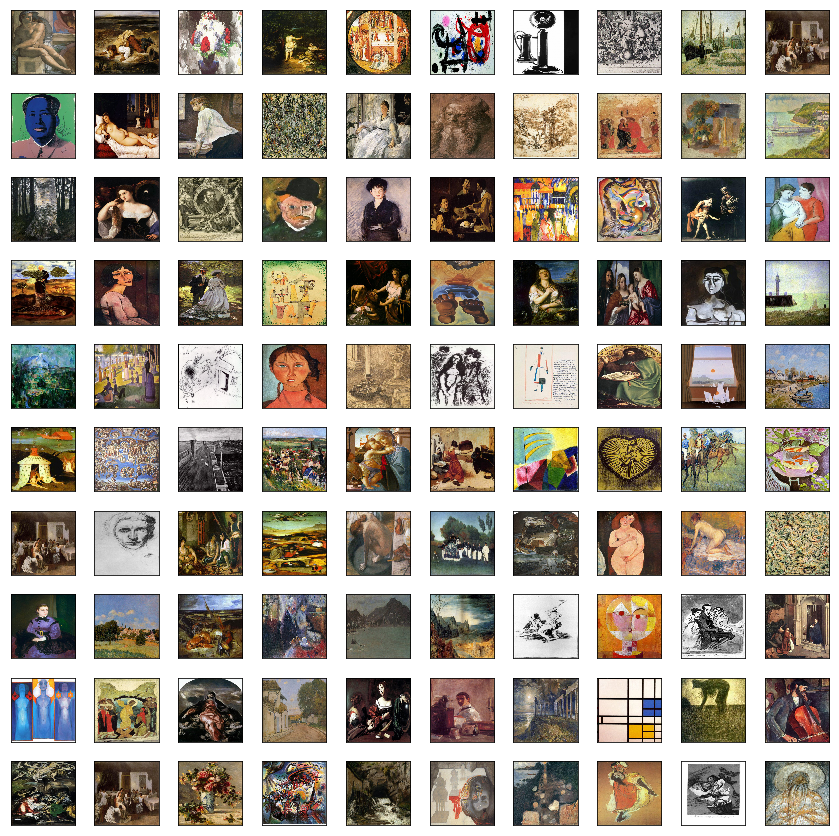

In [17]:
plot_images(image_dir, image_labels, examples=100, disp_labels=False)


The images look OK, except for a few slight distortions due to <b>sk-image</b>'s resizing function.

<a id='section3'></a>
### Creating features from the dataset

Next, let's create the features that we'll use later for training. The input parameters have already been specified so we just need to make a subset of images (random again) and store them to a <b>numpy</b> array. I will first load the images into an array with preserved range (<b>[0,255]</b>) and then manually normalize the input (<b>[0,1]</b>) to speed up the computations a little bit. We will ignore the labels, since this isn't a classification task (they are only used to select a random image class for each iteration).

I will also use <b> joblib </b> to store the features to disk so I can create them faster in the future.

In [0]:
def load_features(directory, labels, image_width=image_width, image_height=image_height, image_channels=image_channels, 
                  sample_size=image_sample_size, loaded=False, features_path=loaded_features_path):
  
    
    if loaded:
        print('Loading saved dataset..')
        if os.path.isfile(features_path):
            features = joblib.load(features_path)
        print('Done')
        return features.astype('float32') / 255.
    
    features = np.zeros((image_sample_size, image_width, image_height, image_channels), dtype=np.uint8)
    for i in range(sample_size):
        rnd_idx_cl = np.random.randint(0, len(labels))
        rnd_class = labels[rnd_idx_cl]
        rnd_idx = np.random.randint(0, len(os.listdir(directory + '/' + rnd_class)))
        filename = os.listdir(directory + '/' + rnd_class)[rnd_idx]
        img = read_image(os.path.join(directory + '/' + rnd_class, filename), width=image_width, height=image_height, channels=
                        image_channels, preserve_range=True)
        features[i] = img
        if i % 100 == 0:
              print(('Processed {:.2f}% of images').format((i/sample_size) * 100))

    print('Done')
    if loaded == False:
        print('Saving dataset to disk..')
        joblib.dump(features, features_path)
    return features.astype('float32') / 255.

In [19]:
#img_features = load_features(directory=image_dir, labels=image_labels)
img_features = load_features(directory=image_dir, labels=image_labels, loaded=True)

Loading saved dataset..
Done


In [20]:
img_features.shape

(2500, 256, 256, 3)

In [21]:
img_features[0]

array([[[0.19215687, 0.14901961, 0.10980392],
        [0.21568628, 0.1764706 , 0.13725491],
        [0.2       , 0.16078432, 0.12156863],
        ...,
        [0.2509804 , 0.22352941, 0.14901961],
        [0.2784314 , 0.25490198, 0.16078432],
        [0.28235295, 0.2627451 , 0.17254902]],

       [[0.23529412, 0.20392157, 0.16078432],
        [0.20784314, 0.18039216, 0.13725491],
        [0.2       , 0.17254902, 0.12941177],
        ...,
        [0.25490198, 0.22745098, 0.18431373],
        [0.2509804 , 0.21960784, 0.16862746],
        [0.2901961 , 0.26666668, 0.2       ]],

       [[0.20392157, 0.1882353 , 0.14117648],
        [0.22745098, 0.21176471, 0.16470589],
        [0.21960784, 0.20784314, 0.16078432],
        ...,
        [0.20784314, 0.18039216, 0.14901961],
        [0.2509804 , 0.22745098, 0.18431373],
        [0.29411766, 0.2784314 , 0.21568628]],

       ...,

       [[0.18431373, 0.14901961, 0.12156863],
        [0.17254902, 0.13725491, 0.10980392],
        [0.14117648, 0

We can see that the shape of the features and the output values are correct so we can continue. Let's visualize them as well to see what they look like. I'll just plot <b>3</b> random ones side by side.

In [0]:
def plot_loaded_features(feature, num_cols=3, num_rows=1, random=1, first_idx=0):
    f, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,8))
    idx = first_idx
    for i in range(num_cols):
        if random:
            idx = np.random.randint(0, len(feature))

        ax[i].grid(False)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        ax[i].imshow(feature[idx])
        idx += 1
        
    plt.show()

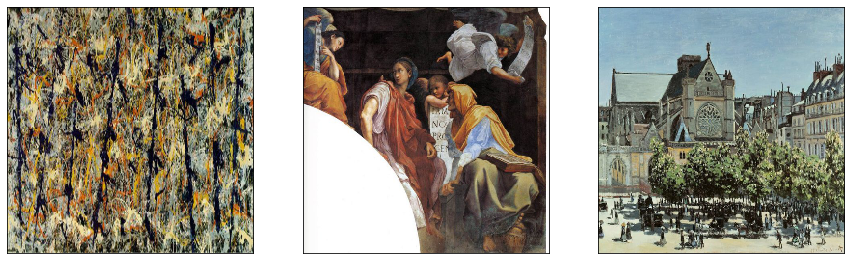

In [23]:
plot_loaded_features(img_features)

Another thing is that the model should not see the colored images in training, or else it will overfit. So we will have to <b>grayscale</b> them before we feed them to the network. From that perspective, let's just confirm that <b>sklearn</b>'s `rgb2gray` function will produce the correct result.

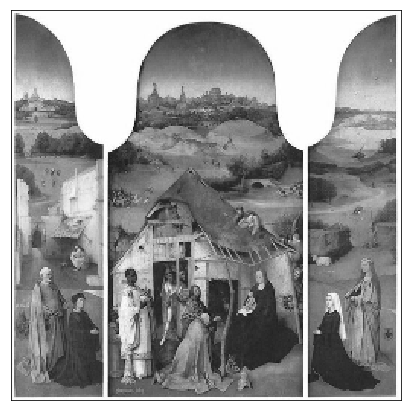

Grayscale image shape:  (256, 256)


In [24]:
imshow(rgb2gray(img_features[10]))
plt.xticks([])
plt.yticks([])
plt.show()
print('Grayscale image shape: ', rgb2gray(img_features[10]).shape)

<a id='section4'></a>
### Data preprocessing and loading Inception weights

Now that we have successfully loaded our features we can create <b>training</b>, <b>test</b> and <b>validation</b> sets. First I will hold out <b>25</b> of the sample of <b>2500</b> images for testing, which will be visualized in a plot after the training is complete. Then I will create a validation set of <b>10%</b> of the remaining images, which will be used for evaluation during training. The remaining <b>90%</b> will be the training images.

In [0]:
features_train, features_test = train_test_split(img_features, test_size=25, random_state=seed)
features_train, features_val = train_test_split(features_train, test_size=0.1, random_state=seed)

In [26]:
print('Train features size: ', features_train.shape)
print('Validation features size: ', features_val.shape)
print('Test features size: ', features_test.shape)

Train features size:  (2227, 256, 256, 3)
Validation features size:  (248, 256, 256, 3)
Test features size:  (25, 256, 256, 3)


As I previously mentioned, the <b>InceptionResNetV2</b> model will be used later on for feature extraction and its outputs will be fused into our model, in order to produce the color predictions. We can either download it from <b>GitHub</b> or just load it from a local file.

In [27]:
# download from github
#inception = InceptionResNetV2(include_top=True)
#inception.graph = tf.get_default_graph()

# or load locally
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights(inception_weights_path)
inception.graph = tf.get_default_graph()

Instructions for updating:
Colocations handled automatically by placer.


Let's print out the structure to see what it looks like.

In [28]:
inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

#### Data Augmentation

Let's add one more preprocessing step for our images - <b>Data Augmentation</b>. It's a very efficient way of generating more samples for training. The generated number of samples will be:

$$ N = BS . E . SPE $$

, where $BS$ - batch size; $E$ - number of epochs; $SPE$ - steps by epoch;

$SPE$ is usually calculated in the following manner:

$$ SPE = \frac{FS}{BS} $$

, where $FS$ - is the number of features or the sample size;

For this attempt, we'll apply a few simple transformations, such as <b>shearing, zooming, rotation and flipping</b>.

In [0]:
batch_size = 20
num_epochs = 30
num_steps_per_epoch = len(features_train) / batch_size
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)

Now, as it stands, the model will create a function that will map the <b>grayscaled</b> input to three color channels: <b>red, green and blue</b>.

![Model predictions with RGB color channels](https://cdn-images-1.medium.com/max/1000/1*W23SQ2oEdE_PsK-HmP4cow.png)

However, we can simplify this function by switching to a simpler color space - <b>Lab</b>. <b>L</b> denotes the pixel brightness, or <b>luminance</b>, <b>a</b> represents the spectra from <b>green</b> to <b>red</b> and b - from <b>blue</b> to <b>yellow</b>. It's basically three color channels packed into two with different ranges (<b>[-128, 128]</b>).
  
  ![Model predictions with Lab color channels](https://cdn-images-1.medium.com/max/1000/1*pZcnvgEuiTUywDgeMF_R3Q.png)
  
So, while were training our model we'll use <b>Keras</b>'s data generator to provide new batches of images in real-time. We'll provide the model with three types of batches: 

1.   <b>The luminance or L of the images, is which basically a grayscaled input encoded in Lab. (The shape is extended with 1 more sample to match Inception's prediction output of 1001 classes)</b>
2.   <b>The inception embeddings - a 1001 class vector containing the predictions for the grayscaled input. (will be explained later on..)</b>
3.   <b>The <i>a</i> and <i>b</i> color spaces for the same images, which will serve as the ground truth, in order to calculate the loss function. (normalized to be in the interval ([-1,1]) to match the network predictions)</b>


  

In [0]:
def augment_data(dataset, batch_size=batch_size):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch

<a id='section5'></a>
### Creating the Colorizer CNN. 

The architure proposed in F. Baldasarre's [paper](https://arxiv.org/pdf/1712.03400.pdf) is an <b>Autoencoder</b> CNN with an extended branch for feature extraction. Here's a quick overview:

![Autoencoder CNN](https://raw.githubusercontent.com/baldassarreFe/deep-koalarization/master/assets/our_net.png)

1. <b>Encoder</b>

&nbsp;&nbsp;&nbsp;Takes a resized version of an input <b>grayscale</b> image <b>H x W</b> and squeezes the image to <b>$\frac{H}{8}$ x $\frac{W}{8}$ x 256</b> to extract information regarding the luminance of the image. The improved version uses a combination of <b>3 x 3</b> and <b>4 x 4</b> filters and the result is downscaled using <b>max pooling</b>.

2. <b>Feature Extractor</b>

&nbsp;&nbsp;&nbsp;Utilizes <b>Inception-ResNet-v2</b> to classify the object in same input image and feed its embedding of <b>1001 class predictions</b> to the <b>Fusion layer</b>.

3. <b>Fusion Layer</b>

&nbsp;&nbsp;&nbsp;This part can be a little bit tricky. The main idea is to take the output from <b>Inception</b> and attach them onto the last encoding layer. To do this the <b>1001 x 1</b> class vector needs to be repeatedly mirrored and expanded across the <b>256</b> depth axis to match the shape of the encoding output layer. After these two outputs are stiched together this produces a <b>$\frac{H}{8}$ x $\frac{W}{8}$ x 1257</b> volume. To even the output of the <b>encoder</b> and the input of the <b>decoder</b> we then apply <b>256 1x1</b> convolutions, which will uniformly distribute the <b>Inception</b> outputs across all space regions and provide this nice mix of semantic and color-based information. 

4. <b> Decoder </b>

&nbsp;&nbsp;&nbsp;The decoder's job is to reconstruct the image in a <b>Lab</b> color space. It uses the same number of convolutional layers as the <b>encoder</b> and uses <b> Upsampling with a factor of 2</b> to reverse the <b>Max pooling</b> and recreate the final shape of the result, which will be: <b>256 x 256 x 2</b>. The predictions generated by the different convolutional layers are mapped using the <b>tanh</b> activation function to produce outputs ranging from <b>[-1, 1]</b>, in order to match the normalized pixel values of the images.

In [0]:
def Colorizer():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

We also need to figure out how to calculate the loss and choose and optimization method for our network. The chosen optimizer here is <b>Adam</b> because it is generally fast for batch processing in neural networks and takes into account past gradients to normalize its output.

The loss is simply calculated using the <b>Mean Squared Error</b> between the estimated <b>a</b> and <b>b</b> pixel values and their real values:

$$ C(X,\theta) = \frac{1}{2HW} \sum_{i=1}^{H} \sum_{j=1}^{W} (X_{k_{i,j}} - \hat{X_{k_{i,j}}})^2 $$

where $X$ is the input image and $\theta$ are all of the model parameters.

In [32]:
model = Colorizer()
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_206

Finally, to create the embedded vector of class outputs from <b>Inception</b>, we need to resize the image to the model's expected input feed it to <b>Keras</b> for further specific preprocessing and simply call `inception.predict()` to get the class vector.

In [0]:
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

Let's also introduce some callbacks to our model, which might help with the training. We'll add <b>learning rate decay</b> with the range <b>[0.001, 0.00001]</b>, which will decrease by <b>0.5</b> if the validation loss hasn't improved for <b>3</b> epochs. I'll also add <b>early stopping</b> to interrupt the training if there hasn't been any improvement in <b>6</b> epochs. Finally I'm going to add a <b>checkpointer</b>, which will be extremely useful for saving the weights of the best model.

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model_stopper = EarlyStopping(monitor='val_loss', patience=6)
model_checkpointer = ModelCheckpoint(trained_model_path + 'best_colorizer.h5',
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')

<a id='section6'></a>
### Evaluating the results.

To evaluate the model we'll introduce a few plots to make a nice presentation of the generated results. To visualize the predictions, we need to reformat the images in the same manner as the previous `augment_data()` function. Then we call `predict()` on the grayscaled images and restore the pixel values to their original <b>RGB</b> range. After that we'll simply make a <b>3x10</b> plot to visualize and compare those predictions to their grayscaled and original counterparts.

In [0]:
def plot_colorization_results(features_test, samples=10):
  
  grayscaled_rgb = gray2rgb(rgb2gray(features_test))
  grayscaled_rgb_embed = create_inception_embedding(grayscaled_rgb)
  grayscaled_rgb = rgb2lab(grayscaled_rgb)[:,:,:,0]
  grayscaled_rgb = grayscaled_rgb.reshape(grayscaled_rgb.shape+(1,))

  output = model.predict([grayscaled_rgb, grayscaled_rgb_embed])
  output = output * 128

  decoded_imgs = np.zeros((len(output),256, 256, 3))
  
  for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = grayscaled_rgb[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    
  fig, axes = plt.subplots(nrows=3, ncols=samples, figsize=(25, 10), subplot_kw = {'xticks':[], 'yticks':[]}, 
                           gridspec_kw = dict(hspace=0.05, wspace=0.01))
  rows = ['{}'.format(row) for row in ['Grayscaled images', 'Colorized images', 'Original images']]
  for ax, row in zip(axes[:,int(samples/2)], rows):
    ax.set_title(row, rotation=0, size='large')
    

  for i, ax in enumerate(axes.flat):
      if i < samples:
        ax.imshow(rgb2gray(features_test)[i].reshape(256, 256), cmap='gray')
      elif i < samples*2 and i >= samples:
        ax.imshow(decoded_imgs[i - samples].reshape(256, 256, 3))
      else:
        ax.imshow(features_test[i - (samples*2)].reshape(256, 256, 3))
      

  plt.show()
  return decoded_imgs

Let's also plot the training and validation loss curve, as well as the learning rate decay across epochs to get a feel for the model performance.

In [0]:
def plot_learning_curves(training_history):
  
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(training_history['loss'], label="Training Loss")
    plt.plot(training_history['val_loss'], label="Validation loss")
    plt.title('Image Colorization: Loss functions')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_history['lr'], label="Learning rate")
    plt.title('Image Colorization: Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.show()

#### Model training

As I previously mentioned, we'll train the model on the <b>augmented</b> version of the dataset and we will apply the same transformations to both the training and validation sets.  

In [0]:
training_history = model.fit_generator(augment_data(features_train, batch_size),
                        epochs=num_epochs,
                        validation_data=augment_data(features_val, batch_size),
                        validation_steps=(len(features_val) / batch_size),
                        steps_per_epoch=num_steps_per_epoch,
                        callbacks=[model_stopper, model_checkpointer, learning_rate_reduction])

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


112/111 [==============================] - 170s 2s/step - loss: 0.0142 - val_loss: 0.0137

Epoch 00001: val_loss improved from inf to 0.01370, saving model to drive/My Drive/Colab Notebooks/Image Colorization/best_colorizer.h5
Epoch 2/30
112/111 [==============================] - 155s 1s/step - loss: 0.0139 - val_loss: 0.0134

Epoch 00002: val_loss improved from 0.01370 to 0.01339, saving model to drive/My Drive/Colab Notebooks/Image Colorization/best_colorizer.h5
Epoch 3/30
112/111 [==============================] - 169s 2s/step - loss: 0.0139 - val_loss: 0.0135

Epoch 00003: val_loss did not improve from 0.01339
Epoch 4/30
112/111 [==============================] - 166s 1s/step - loss: 0.0137 - val_loss: 0.0132

Epoch 00004: val_loss improved from 0.01339 to 0.01318, saving model to drive/My Drive/Colab Notebooks/Image Colorization/best_colorizer.h5
Epoch 5/30
112/111 [==============================] - 168s 1s/step - loss: 0.0137 - val_loss: 0.0133

Epoch 00005: val_loss did not impr

After the training has finished we can call `model.load_weights()` and `model.save_weights()` to save and load the current model weights locally.

In [0]:
#model.save(trained_model_path + 'colorization_model.h5')
#model.save_weights(trained_model_path + 'colorization_weights.h5')
model.load_weights(trained_model_path + 'colorization_weights.h5')

In order to preserve the model history as well, I will also make two quick helper functions for saving that information to a <b>JSON</b> file and loading it afterwards.

In [0]:
def save_hist(filename, history):
    with open(filename, "w") as write_file:
        json.dump(history, write_file)
def load_hist(filename):
    with open(filename, 'r', encoding='utf-8') as read_file:
        train_hist = json.loads(read_file.read())
        return train_hist

In [0]:
#save_hist(trained_model_path + 'colorization_model.json', str(training_history.history))
training_history = load_hist(trained_model_path + 'colorization_model.json')

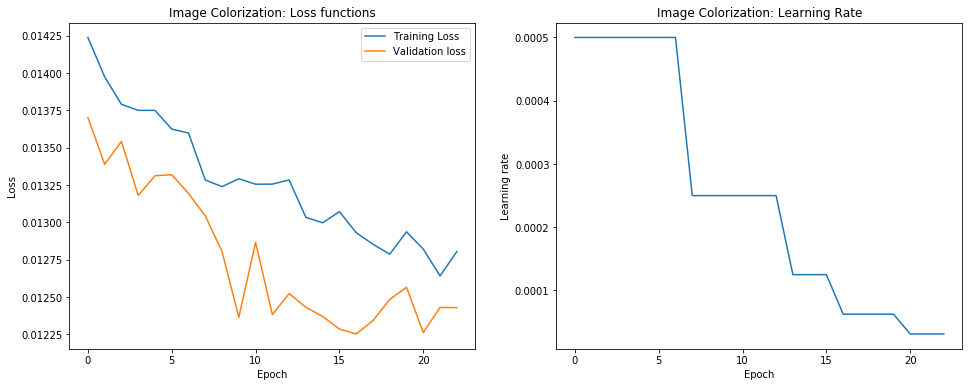

In [40]:
#plot_learning_curves(training_history.history)
plot_learning_curves(eval(training_history))

As we can see from the plots, the validation loss is quite a lot more noisier than the training loss, but in general it does go in the right direction. The model is still no where near close to its optimum since the values are still fluctuating.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


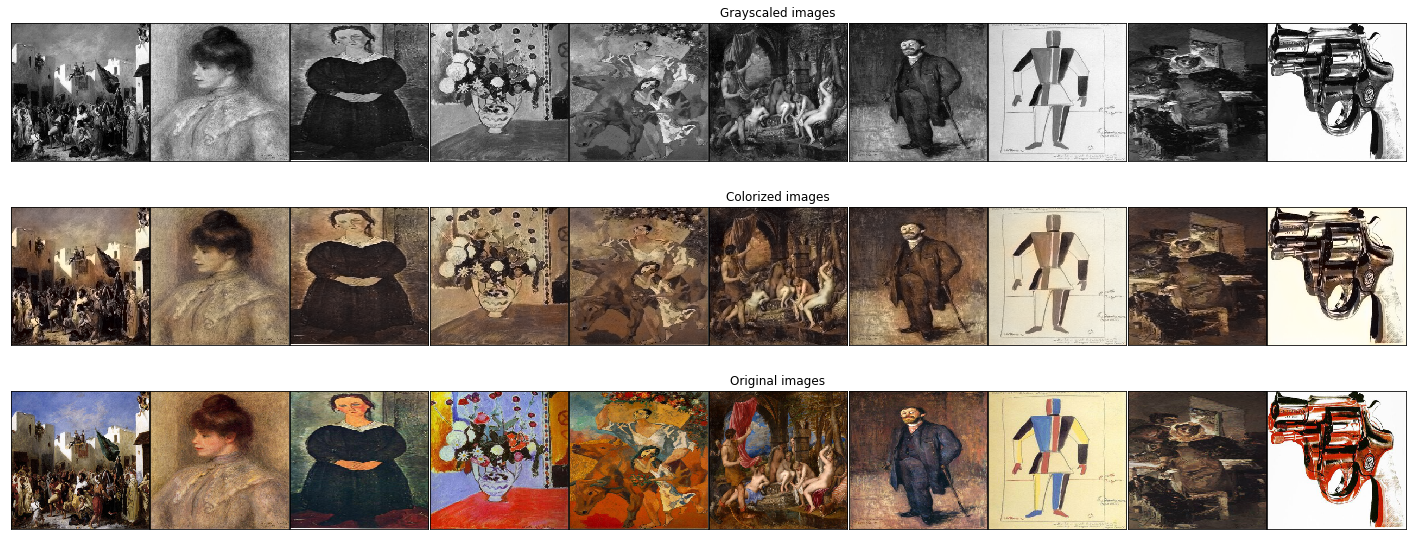

In [45]:
decoded_test_imgs = plot_colorization_results(features_test)

The plotted predictions have indeed been colored, but mostly with brownish colors, with a few slight exceptions. Let's take a closer look.

In [46]:
for i in range(len(decoded_test_imgs)):
  plt.imshow(decoded_test_imgs[i])
  plt.xticks([])
  plt.yticks([])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In some of the samples, there some interesting random splashes of other colors as well, but nothing really impressive. Let's try to optimize this model just a little bit more.

<a id='section7'></a>
### Further optimizations. 

We'll lower the batch size a little bit and increase the steps the model takes for each epoch. In addition, we'll also decrease the transformation factors in the augmentation, because they might be generating more noisy outputs. Finally, let's also remove the <b>Early Stopping</b> callback to allow the model to train to its fullest for <b>30</b> epochs.

In [0]:
batch_size = 16
num_epochs = 30
num_steps_per_epoch = len(features_train) / batch_size
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10,
        horizontal_flip=True)

In [0]:
training_history = model.fit_generator(augment_data(features_train, batch_size),
                        epochs=num_epochs,
                        validation_data=augment_data(features_val, batch_size),
                        validation_steps=(len(features_val) / batch_size),
                        steps_per_epoch=num_steps_per_epoch,
                        callbacks=[model_checkpointer, learning_rate_reduction])

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


140/139 [==============================] - 413s 3s/step - loss: 0.0139 - val_loss: 0.0138

Epoch 00001: val_loss improved from inf to 0.01383, saving model to drive/My Drive/Colab Notebooks/Image Colorization/best_colorizer.h5
Epoch 2/30
140/139 [==============================] - 383s 3s/step - loss: 0.0138 - val_loss: 0.0134

Epoch 00002: val_loss improved from 0.01383 to 0.01343, saving model to drive/My Drive/Colab Notebooks/Image Colorization/best_colorizer.h5
Epoch 3/30
140/139 [==============================] - 385s 3s/step - loss: 0.0138 - val_loss: 0.0132

Epoch 00003: val_loss improved from 0.01343 to 0.01324, saving model to drive/My Drive/Colab Notebooks/Image Colorization/best_colorizer.h5
Epoch 4/30
140/139 [==============================] - 386s 3s/step - loss: 0.0137 - val_loss: 0.0136

Epoch 00004: val_loss did not improve from 0.01324
Epoch 5/30
140/139 [==============================] - 395s 3s/step - loss: 0.0137 - val_loss: 0.0132

Epoch 00005: val_loss improved fro

After training, we save the best weights and the history again..

In [0]:
#model.save(trained_model_path + 'colorization_model_opt.h5')
#model.save_weights(trained_model_path + 'colorization_weights_opt.h5')
model.load_weights(trained_model_path + 'colorization_weights_opt.h5')

In [0]:
#save_hist(trained_model_path + 'colorization_model_opt.json', str(training_history.history))
training_history = load_hist(trained_model_path + 'colorization_model_opt.json')

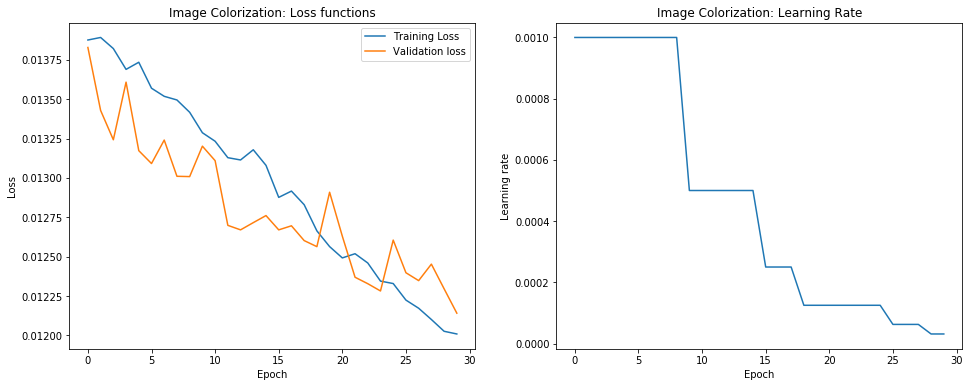

In [50]:
#plot_learning_curves(training_history.history)
plot_learning_curves(eval(training_history))

The training curve seems a lot more normalized now, however the validation loss still fluctuates even above the training loss. Despite this fact, I still think the model is learning in the right direction and it's just <b>underfit</b>.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 20 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


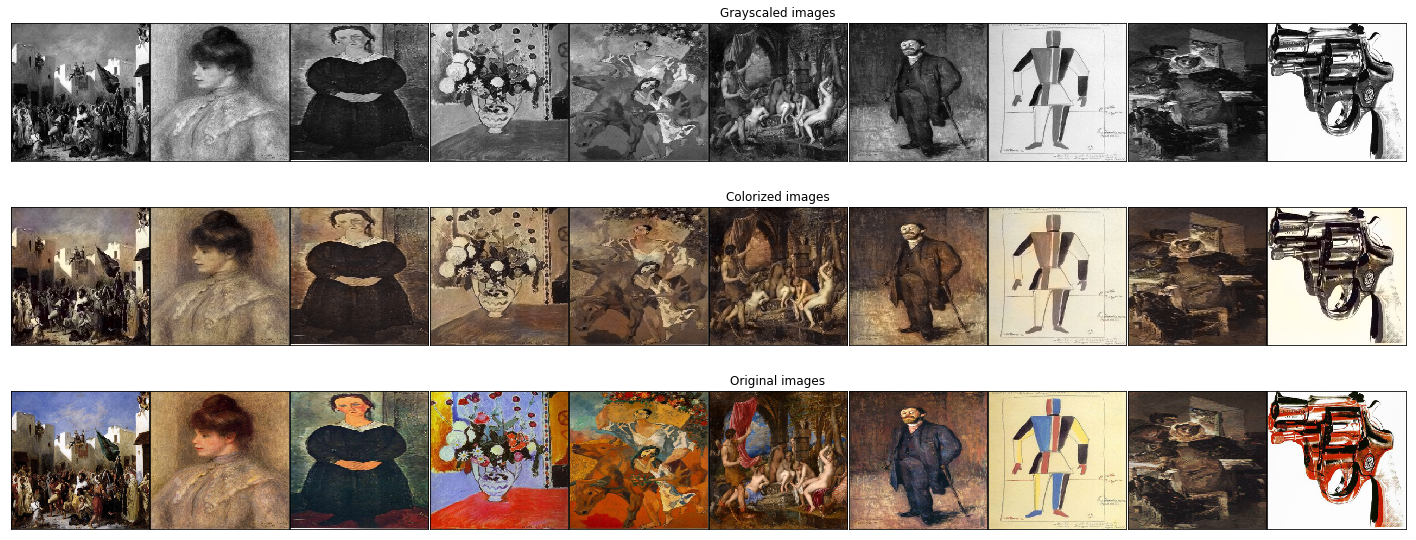

In [51]:
decoded_test_imgs = plot_colorization_results(features_test)

The generated images look more or less the same as before with a few exceptions.

In [52]:
for i in range(len(decoded_test_imgs)):
  plt.imshow(decoded_test_imgs[i])
  plt.xticks([])
  plt.yticks([])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

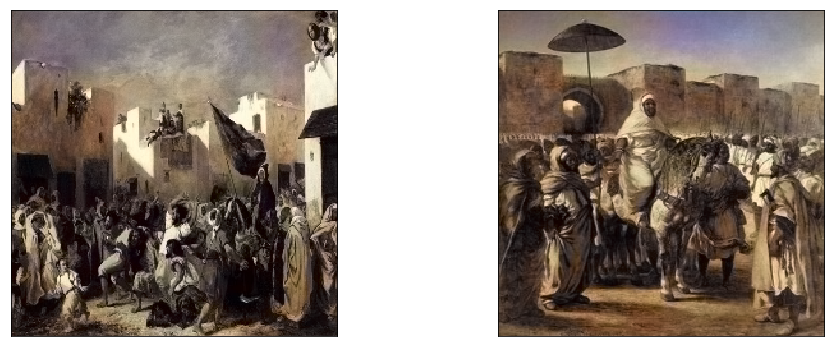

In [53]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(decoded_test_imgs[0])
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(decoded_test_imgs[10])

plt.show()

In these samples, we can see that the sky has indeed been splashed with blue-ish colors in a few places and this is another sign that model is moving in the right direction.

<a id='section8'></a>
### Testing the model with images of unknown color. 

Let's also try to use the colorizer for images that have unknown color in the first place. I'll use a function to load and resize three samples, similar to the one where I created the features.

In [0]:
def load_test_images(directory, image_sample_size=3, image_width=image_width, image_height=image_height, 
                     image_channels=image_channels):
    
    features = np.zeros((image_sample_size, image_width, image_height, image_channels), dtype=np.uint8)
    idx = 0
    for image_file in os.listdir(directory):
        img = read_image(os.path.join(directory, image_file), width=image_width, height=image_height, channels=
                        image_channels, preserve_range=True)
        features[idx] = img
        idx = idx + 1

    print('Done')
    return features.astype('float32') / 255.

In [55]:
test_images = load_test_images(directory=test_image_path)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Done


Afterwards, we'll use the same transformations as before to plot the predictions side by side.

In [0]:
def colorize_test_images(features_test, samples=3):
  
  grayscaled_rgb = gray2rgb(rgb2gray(features_test))
  grayscaled_rgb_embed = create_inception_embedding(grayscaled_rgb)
  grayscaled_rgb = rgb2lab(grayscaled_rgb)[:,:,:,0]
  grayscaled_rgb = grayscaled_rgb.reshape(grayscaled_rgb.shape+(1,))

  output = model.predict([grayscaled_rgb, grayscaled_rgb_embed])
  output = output * 128

  decoded_imgs = np.zeros((len(output),256, 256, 3))
  
  for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = grayscaled_rgb[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    
  fig, axes = plt.subplots(nrows=2, ncols=samples, figsize=(16, 14), subplot_kw = {'xticks':[], 'yticks':[]}, 
                           gridspec_kw = dict(hspace=0.25, wspace=0.01))
  rows = ['{}'.format(row) for row in ['Colorized images', 'Original images']]
  for ax, row in zip(axes[:,int(samples/2)], rows):
    ax.set_title(row, rotation=0, size='large')
    

  for i, ax in enumerate(axes.flat):
      if i < samples:
        ax.imshow(decoded_imgs[i].reshape(256, 256, 3))
      else:
        ax.imshow(features_test[i - samples].reshape(256, 256, 3))
      

  plt.show()
  return decoded_imgs

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


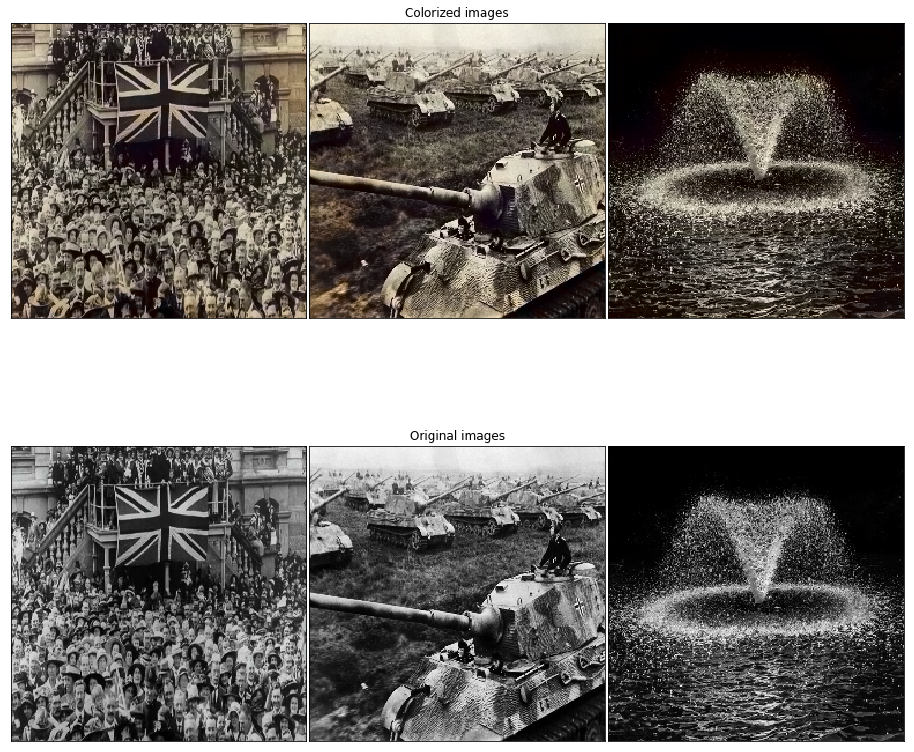

In [57]:
test_colorized_images = colorize_test_images(test_images)

Well as expected, the images are mostly colored with brown-ish splashes, mostly around their corners. There is still a lot of room for improvement but I think this is a good stopping poing for this notebook for now.

<a id='section9'></a>
### <center>Conclusion</center> 

&nbsp;&nbsp;&nbsp;To conclude, I used a dataset of historical artworks and fed it to an extended <b>Autoencoder CNN</b>, producing the predicted pixel values of their grayscaled version in a <b>Lab</b> color space. <b>Inception</b>'s class vector of predictions was concatenated to the <b>Encoder</b>'s outputs and reduced to combine the semantic and color-related representations of the input images. In the evaluation, the model produced images with mostly brownish colors with slight sights of blue and red in some samples. This proves that the network still has a lot learn, but has the potential to complete an accurate colorization task.

### <center>Further improvements</center>

There are lot of things that could be done to improve the model performance, which are left as an exercise to the reader (and the writer ^^):



*   Try to use different image datasets.
*   Train the model for longer.
*   Optimize the augmentation transformations.
*   Optimize the <i>optimizer</i> and its learning rate.
*   Create a more complex loss function to get a more accurate representation of the pixel values.
*   Try to train the model with more samples.
*   Improve the model architecture.



### <center>Resources</center>



1.   Baldasarre F., Morin D.G., Rodes-Guirao L. - [Deep Koalarization: Image Colorization using CNNs and Inception-Resnet-v2](https://arxiv.org/pdf/1712.03400.pdf)
2.   Wallner E. - [How to colorize black & white photos with just 100 lines of neural network code](https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d)
3. Chollet, F., et al. -  [Keras](https://github.com/fchollet/keras)
4.  Goodfellow, I., Bengio, Y., Courville, A. - [Deep Learning. MIT Press (2016)](http://www.deeplearningbook.org)
5.  Kingma,  D.P.,  Ba,  J. - [Adam:  A  method  for  stochastic  optimization](https://arxiv.org/pdf/1412.6980.pdf)
6.  Szegedy C., Ioffe S., Vanhoucke V., Alemi A. - [Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/pdf/1602.07261.pdf)




### <center>Communication and contacts</center>

If you have any questions, criticism or suggestions feel free to email me at: dragonflareful@gmail.com.

This project will be shared on my GitHub page: https://github.com/JadeBlue96 and it will be free to fork, use and manipulate to the public. It will also be available for reproduction in <b>Google Colab</b>.

I will also appreciate any type of feedback on this matter.


### <center>Acknowledgements</center>

Special thanks to Yordan Darakchiev for his insights and examples on his AI courses at [SoftUni](softuni.com), F. Baldasarre and his team for creating this model and E. Wallner for providing a detailed tutorial regarding the intuition behind it.
